In [36]:
from smap.archiver.client import SmapClient                                                                                                                                                                                                                                                                                   
from smap.contrib import dtutil                                                                                                                                                                                                                                                                                               
import json                                                                                                                                                                                                                                                                                                                   
import sys      
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
%matplotlib inline

In [2]:
# fetch data
c = SmapClient("http://new.openbms.org:8079")
print c
uuid_file = "SDH_floor_4_temperature_uuids.json"
start_time = dtutil.dt2ts(dtutil.strptime_tz("10-30-2016", "%m-%d-%Y"))
end_time = dtutil.dt2ts(dtutil.strptime_tz("11-30-2016", "%m-%d-%Y"))
                                                                                                                                                                                                                                                                                                                              
print uuid_file                                                                                                                                                                                                                                                                                                               
uuids = json.load(open(uuid_file))
data = c.data_uuid(uuids, start_time, end_time,limit=10000)

<smap.archiver.client.SmapClient instance at 0x7f7dbd991cb0>
SDH_floor_4_temperature_uuids.json

downloaded 1584b from 24 urls in 0.766s (0.002MB/s download: 0.766s, parse: 0.000845s)


In [28]:
metadata_file = 'SDH_floor_4_metadata.json'
_metadata = json.load(open(metadata_file))
sensor_metadata = {}
for doc in _metadata:
    sensor_metadata[doc['uuid']] = doc
    sensor_metadata[doc['Metadata']['Instrument']['PartNumber']] = doc

# grab VAV metadata
_metadata = c.query("select * where Metadata/SourceName = 'Sutardja Dai Hall BACnet' and Path ~ '.*ROOM_TEMP' and Metadata/Extra/Vav ~ 'S4.*'")
print _metadata[0]
vav_metadata = {}
for doc in _metadata:
    vavid = doc['Metadata']['Extra']['Vav']
    room = doc['Description'].split(' ')[0]
    uuid = doc['uuid']
    insert = {
            'VAV': vavid,
            'Room': room,
            'uuid': uuid,
        }
    vav_metadata[vavid] = insert
    vav_metadata[room] = insert
    vav_metadata[uuid] = insert

def uuid_to_ketiid(uuid):
    return sensor_metadata[uuid]['Metadata']['Instrument']['PartNumber']
def ketiid_to_vavid(ketiid):
    vav = sensor_metadata[ketiid]['Metadata']['Extra']['VAV']
    print ketiid, vav
    

{'Path': '/Siemens/SDH.PXCM-11/SDH/S4-19/ROOM_TEMP', 'uuid': 'a7aad37c-6dd8-5252-8443-65471582f8e9', 'Metadata': {'SourceName': 'Sutardja Dai Hall BACnet', 'Location': {'Building': 'Sutardja Dai Hall', 'Campus': 'UCB'}, 'PointName': 'SDH.S4-19:ROOM TEMP', 'Extra': {'Type': 'room temperature', 'Vav': 'S4-19'}}, 'Properties': {'Timezone': 'America/Los_Angeles', 'UnitofMeasure': 'F', 'ReadingType': 'double'}, 'Description': '477 WOMENS BATH'}


In [29]:
# build data frames
temperatures = {}
for uuid, datas in zip(uuids, data):             
    if len(datas) == 0: continue
    df = pd.DataFrame.from_records(datas)
    df = df.set_index(pd.to_datetime(df.pop(0), unit='ms'))
    df = df.resample('5min').mean()
    df.columns = [uuid_to_ketiid(uuid)]
    temperatures[uuid] = df
    print uuid, df.count()

0bfbd947-40a2-5454-a352-1375790c604d 1707    4763
dtype: int64
19dac044-e8ae-5ed4-a789-a46d2cd9d375 1709    7964
dtype: int64
1f17fd93-8009-5153-926f-54395c421d93 1715    162
dtype: int64
27e71c02-6a7c-5d29-9d7e-3b437f9f6c46 1706    6128
dtype: int64
2a756197-f1b3-56eb-ab87-a61111bdd80b 1624    438
dtype: int64
2e22715f-9d3e-5c5d-b90c-8b6226e29cca 1712    7975
dtype: int64
31e75b66-41bf-518d-a144-f3e144f396e5 1713    7978
dtype: int64
3d4496b0-63e8-5d88-890a-cbce6f1202a6 1716    7977
dtype: int64
41d4673c-0926-5c58-91a3-7c440ed6962c 1631    1854
dtype: int64
4fa00ebf-6387-5183-b987-2b54e1031ec4 1627    4278
dtype: int64
6b0b7685-fd48-5d27-840c-d730ed6681d7 1628    688
dtype: int64
6d03bfef-f70e-5c58-953c-d9b52c41835c 1632    2969
dtype: int64
9165f400-355d-506a-8afa-421273d02010 1702    409
dtype: int64
a988771e-b6c8-5b2e-9c23-ad88e5efe3e6 1630    377
dtype: int64
c796ac06-e7fc-5127-b105-ebc3101a43be 1622    7954
dtype: int64
d0184967-52c2-5c3f-ad90-6e49f10faa7e 1629    7974
dtype: int

In [30]:
print len(temperatures)

16


8600


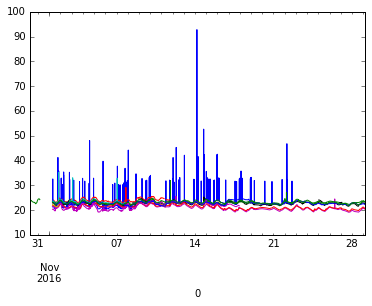

In [31]:
# merge all timeseries into the same data frame
dfs = temperatures.values()
current = dfs[0]
for df in dfs[1:]:
    current = current.merge(df, how='outer',left_index=True, right_index=True)
print len(current)
current.plot(legend=False)

In [32]:
df = current.copy()

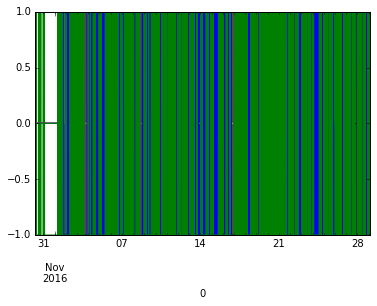

In [33]:
# compute whether or not temperature going up or not
diffs = df.interpolate(method='time').diff(axis=0)
diffs[diffs > 0] = 1
diffs[diffs < 0] = -1
diffs = diffs.fillna(0)
diffs.plot(legend=False)

In [34]:
diffs.tail()

,1706,1702,1632,1630,1712,1627,1629,1628,1716,1713,1631,1707,1715,1624,1709,1622
0,,,,,,,,,,,,,,,,
2016-11-29 03:15:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2016-11-29 03:20:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2016-11-29 03:25:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2016-11-29 03:30:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2016-11-29 03:35:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0


In [35]:
diffs.to_csv("idea1.csv",sep="\t",header=True,index=False)

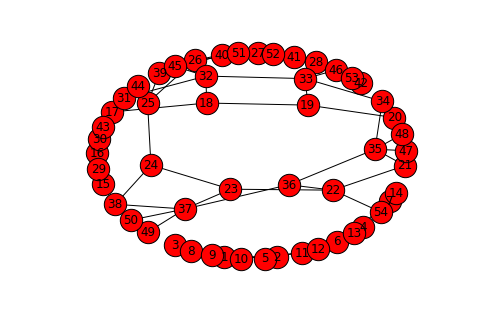

In [63]:
# Generate the SDH graph
nodes = range(1,55) # 1 - 54
edges = [
    (1,8),
    (8,9),
    (9,2),
    (9,10),
    (10,3),
    (10,11),
    (11,4),
    (11,12),
    (12,5),
    (12,13),
    (13,6),
    (13,14),
    (14,7),
    (14,54),
    (54,22),
    (15,16),
    (16,17),
    (17,18),
    (18,19),
    (19,20),
    (20,21),
    (21,22),
    (22,23),
    (23,24),
    (24,25),
    (25,26),
    (26,27),
    (27,28),
    (42,53),
    (15,29),
    (29,30),
    (30,31),
    (31,32),
    (32,33),
    (33,34),
    (34,35),
    (35,36),
    (36,37),
    (37,38),
    (39,40),
    (40,41),
    (41,42),
    (16,30),
    (17,31),
    (18,32),
    (19,33),
    (20,34),
    (21,35),
    (22,36),
    (23,37),
    (24,38),
    (25,39),
    (26,40),
    (27,41),
    (28,42),
    (30,43),
    (31,44),
    (32,45),
    (33,46),
    (35,47),
    (35,48),
    (37,49),
    (37,50),
    (40,51),
    (40,52)
]
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, iterations=500)
nx.draw(G,pos,node_size=500,with_labels=True)